In [1]:
import jax
import jax.numpy as jnp

import mfvi

import jax.scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
observed = jax.random.normal(jax.random.PRNGKey(1), shape=(100,1)) + 10 * 2

def loglikelihood_fn(params, batch):
    logpdf = stats.norm.logpdf(batch, params[0], 1)
    return jnp.sum(logpdf)

def prior_fn(params):
    return stats.norm.logpdf(params[0], 10, 1)

def logjoint_fn(params, batch):
    return prior_fn(params) + loglikelihood_fn(params, batch)


def batch_data(rng_key, data, batch_size, data_size):
    """Return an iterator over batches of data."""
    while True:
        _, rng_key = jax.random.split(rng_key)
        idxs = jax.random.choice(
            key=rng_key, a=jnp.arange(data_size), shape=(batch_size,)
        )
        minibatch = jnp.array(tuple(data[idx] for idx in idxs))
        yield minibatch

(array([ 1.,  1.,  1.,  7., 11., 14.,  6.,  4.,  3.,  2.]),
 array([16.96600342, 17.2378273 , 17.50964928, 17.78147125, 18.05329514,
        18.32511902, 18.59694099, 18.86876297, 19.14058685, 19.41241074,
        19.68423271]),
 <BarContainer object of 10 artists>)

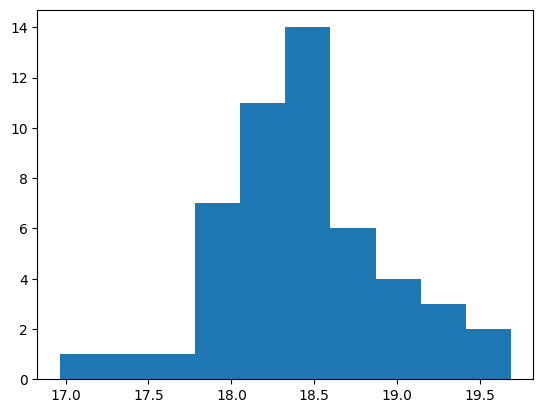

In [12]:
key = jax.random.PRNGKey(123)



mu = jnp.array(15.)
rho = jnp.array(2.)
params = mu, rho



num_steps = 25
key, subkey = jax.random.split(key)
batches = batch_data(subkey, observed, 50, 100)

for step in range(num_steps):

    batch = next(batches)

    sampled_params, key = mfvi.meanfield_sample(params, key, n_samples=5)

    # evaluate elbo
    (elbo, key), grad  =  jax.value_and_grad(
            mfvi.meanfield_elbo, has_aux=True
        )(params, batch, key, logjoint_fn, 3)


    params = jax.tree_map(lambda p, g: p - 0.001 * g, params, grad)


posterior_samples, _ = mfvi.meanfield_sample(params, key, 50)
plt.hist(posterior_samples)